# Overview

This script does more-or-less the same thing as [the singular variant](./gateway_aggregator_analysis_singular.ipynb), however, aggregates the results of different results, and performs trend analysis across different configurations (accessible vCPUs etc.).

In [230]:
import datetime
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import typing

import seaborn as sns

MAX_STEPS = 25
MAX_CORES = 8

base_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/"

pincirollis_data_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/pincirolli_results.csv"
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

,N_A,N_B,r_Z_A,r_Z_B,r_A_gw,r_B_gw,r_A_s1,r_B_s1,r_A_s2,r_B_s2,...,Us1,Us1_low,Us1_up,Us2,Us2_low,Us2_up,Us3,Us3_low,Us3_up,sim_time_sec
count,26.000000,26.000000,26.00,26.00,2.600000e+01,2.600000e+01,26.000000,2.600000e+01,26.000000,2.600000e+01,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,12.500000,12.500000,0.01,0.01,1.000000e-01,1.000000e-01,0.142857,5.555556e-02,0.066667,8.333333e-02,...,0.834549,0.817965,0.851132,0.881542,0.862390,0.900694,0.803144,0.786958,0.819330,16.271223
std,7.648529,7.648529,0.00,0.00,1.415262e-17,1.415262e-17,0.000000,7.076311e-18,0.000000,1.415262e-17,...,0.202529,0.201185,0.204015,0.099613,0.099847,0.099446,0.228313,0.225822,0.230913,6.905904
min,0.000000,0.000000,0.01,0.01,1.000000e-01,1.000000e-01,0.142857,5.555556e-02,0.066667,8.333333e-02,...,0.350410,0.341256,0.359564,0.663446,0.646140,0.680753,0.280486,0.273303,0.287669,6.891319
25%,6.250000,6.250000,0.01,0.01,1.000000e-01,1.000000e-01,0.142857,5.555556e-02,0.066667,8.333333e-02,...,0.730555,0.712574,0.748535,0.819044,0.795895,0.842193,0.668579,0.655058,0.682099,10.525236
50%,12.500000,12.500000,0.01,0.01,1.000000e-01,1.000000e-01,0.142857,5.555556e-02,0.066667,8.333333e-02,...,0.929473,0.902100,0.955138,0.916168,0.897617,0.934720,0.899154,0.879224,0.919083,17.929612
75%,18.750000,18.750000,0.01,0.01,1.000000e-01,1.000000e-01,0.142857,5.555556e-02,0.066667,8.333333e-02,...,0.998378,0.985836,1.010920,0.971146,0.950376,0.991736,0.995618,0.972707,1.008472,19.323439
max,25.000000,25.000000,0.01,0.01,1.000000e-01,1.000000e-01,0.142857,5.555556e-02,0.066667,8.333333e-02,...,1.000000,0.987486,1.012514,0.986433,0.972145,1.001660,1.000000,0.987486,1.028648,39.616759


# Dataframe creation

In [231]:
# Generates data from the step data

columns = [
    # Experiment Metadata
    "s3_intensity",
    "run_index",
    "replications",
    "trials",
    "cpu_cap",
    # Other metadata
    "experiment_start",
    "experiment_stop",
    # Results latency
    "real_avg_latency_ms",
    "synth_latency_ms",
    # Results CPU utilization.
    "cpu_utilization_readings",
]
# Results CPU utilization.
services = ["s1", "s2", "s3", "gateway-aggregator"]
columns.extend([f"{service}_real_avg_cpu_utilization" for service in services])
columns.extend([f"{service}_synth_cpu_utilization" for service in services])

df = pd.DataFrame(columns=columns)


# Utility functions.
def get_subfolders(parent_dir) -> typing.Iterator[str]:
    return [
        f"{parent_dir}/{name}"
        for name in os.listdir(parent_dir)
        if os.path.isdir(f"{parent_dir}/{name}")
    ]


def iterate_through_folders(parent_dir: str) -> typing.Iterator[str]:
    for subdirectory in get_subfolders(parent_dir):
        for directory in get_subfolders(subdirectory):
            yield directory

In [232]:
# Loads latency data


def get_experiment_start_end_time(
    dir_name: str,
) -> typing.Tuple[datetime.datetime, datetime.datetime]:
    TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
    with open(f"{dir_name}/metadata.json", "r", encoding="utf-8") as metadata_file:
        j_data = json.loads(metadata_file.read())
    start_time = datetime.datetime.strptime(j_data["start_time"], TIME_FORMAT)
    end_time = datetime.datetime.strptime(j_data["end_time"], TIME_FORMAT)
    return start_time, end_time


def lies_outside_timewindow(
    timestamp: str, start: datetime.date, end: datetime.datetime, time_format: str
) -> bool:
    """Returns true if the provided timestamp lies outside the provided window."""
    timestamp = datetime.datetime.strptime(timestamp, time_format)
    return timestamp < start and timestamp > end


def get_utilization_data(dir_name: str):
    TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

    # Filters CPU utilization features by using the experiment's time window.
    exp_df = pd.read_csv(f"{dir_name}/cpu_utilization.csv", header=0)
    indices_outside_timewindow = [
        index
        for index in exp_df.index
        if lies_outside_timewindow(index, start_time, end_time, TIMEFORMAT_2)
    ]
    exp_df = exp_df.drop(indices_outside_timewindow)

    # Some reading can be incomplete; these are dropped.
    exp_df = exp_df.dropna()

    # Constructs average CPU utilization datapoint.
    data_point = [np.average(exp_df[col]) for col in services]
    n = len(exp_df)

    return data_point, n


def get_mubench_results(dir_name: str):
    path = f"{dir_name}/mubench_results.csv"
    exp_df = pd.read_csv(path, header=0)
    avg_latency = np.average(exp_df["latency_ms"])
    return avg_latency


def get_experiment_metadata(dir_name: str):
    *cpu_cap, replications, trials = os.path.basename(experiment_folder).split("_")
    if len(cpu_cap) == 1:
        cpu_cap = int(cpu_cap[0][:-1])
    else:
        # No CPU cap.
        cpu_cap = round(MAX_CORES / 3.0 * 1000)
    replications = int(replications[: -len("rep")])
    trials = int(trials[: -len("trials")])
    return cpu_cap, replications, trials


data_point_counter = 0

for experiment_folder in iterate_through_folders(base_path):
    cpu_cap, replications, trials = get_experiment_metadata(experiment_folder)
    for run_folder in get_subfolders(experiment_folder):
        _, run = os.path.basename(run_folder).split("_")
        for step_folder in get_subfolders(run_folder):
            # Metadata
            step, _ = os.path.basename(step_folder).split("_")
            step = int(step)
            s3_intensity = 1 - (step / MAX_STEPS)
            start_time, end_time = get_experiment_start_end_time(step_folder)

            # Synthetic data point relevant to current step.
            synth_data_point = synth_df[synth_df["N_A"] == MAX_STEPS - step]

            # Request latency
            real_avg_latency_ms = get_mubench_results(step_folder)
            synth_latency_ms = synth_data_point["R0"].values[0]

            # CPU utilizatoin
            utilization_data, n_utilization_readings = get_utilization_data(step_folder)
            synth_utilization_data = synth_data_point[
                ["Ugw", "Us1", "Us2", "Us3"]
            ].values[0]

            # Constructs datapoint.
            data_point = [
                s3_intensity,
                int(run),
                replications,
                trials,
                cpu_cap,
                start_time,
                end_time,
                real_avg_latency_ms,
                synth_latency_ms,
                n_utilization_readings,
                *utilization_data,
                *synth_utilization_data,
            ]
            df.loc[data_point_counter, :] = data_point
            data_point_counter += 1

df

,s3_intensity,run_index,replications,trials,cpu_cap,experiment_start,experiment_stop,real_avg_latency_ms,synth_latency_ms,cpu_utilization_readings,s1_real_avg_cpu_utilization,s2_real_avg_cpu_utilization,s3_real_avg_cpu_utilization,gateway-aggregator_real_avg_cpu_utilization,s1_synth_cpu_utilization,s2_synth_cpu_utilization,s3_synth_cpu_utilization,gateway-aggregator_synth_cpu_utilization
0,1.0,1,1,25,1000,2023-11-11 01:49:57,2023-11-11 02:35:25,2884.173333,501.080456,25,0.282343,0.616087,0.926202,0.040694,0.498132,0.35041,0.739736,1.0
1,0.6,1,1,25,1000,2023-11-10 21:34:38,2023-11-10 22:08:25,2148.422733,349.225049,19,0.391679,0.60038,0.923595,0.047188,0.716111,0.859453,0.98562,0.951204
2,0.56,1,1,25,1000,2023-11-10 22:47:46,2023-11-10 23:11:23,1496.928067,343.407534,14,0.578368,0.899169,0.798558,0.06363,0.734507,0.894702,0.981409,0.930461
3,0.52,1,1,25,1000,2023-11-11 03:02:59,2023-11-11 03:24:44,1376.792067,343.794083,13,0.910623,0.95832,0.751289,0.069928,0.721819,0.914074,0.986433,0.902571
4,0.48,1,1,25,1000,2023-11-11 03:25:15,2023-11-11 03:49:25,1533.284933,342.210564,14,0.662176,0.929034,0.815147,0.065789,0.730264,0.944872,0.981074,0.895737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.8,1,1,25,2667,2023-11-14 07:09:52,2023-11-14 07:14:15,267.265333,387.771535,4,1.061866,2.32356,3.137645,0.147855,0.645042,0.6658,0.910665,0.999964
235,0.76,1,1,25,2667,2023-11-14 06:41:01,2023-11-14 06:45:33,258.3094,373.134026,4,1.958111,2.36596,2.102494,0.161548,0.666261,0.720328,0.935504,0.998358
236,0.72,1,1,25,2667,2023-11-14 06:54:44,2023-11-14 06:58:40,235.390133,363.374229,4,2.159539,2.599329,1.623799,0.168233,0.684428,0.761235,0.951787,0.987397
237,0.68,1,1,25,2667,2023-11-14 05:32:55,2023-11-14 05:37:04,249.895467,357.479974,4,1.900705,2.505791,2.18761,0.163192,0.701355,0.80498,0.971329,0.981367


# Request Delay

## One replica + vCPU caps

In [233]:
or_df = df[df["replications"] == 1]
or_df.describe()

or_df = or_df.groupby(['cpu_cap', 's3_intensity']).mean().reset_index()

or_df


,cpu_cap,s3_intensity,run_index,replications,trials,experiment_start,experiment_stop,real_avg_latency_ms,synth_latency_ms,cpu_utilization_readings,s1_real_avg_cpu_utilization,s2_real_avg_cpu_utilization,s3_real_avg_cpu_utilization,gateway-aggregator_real_avg_cpu_utilization,s1_synth_cpu_utilization,s2_synth_cpu_utilization,s3_synth_cpu_utilization,gateway-aggregator_synth_cpu_utilization
0,500,0.00,1.0,1.0,25.0,2023-11-13 03:35:58,2023-11-13 04:56:40,5150.709267,449.008131,43.0,0.481472,0.267964,0.108159,0.023713,0.560574,0.999943,0.663446,0.280486
1,500,0.04,1.0,1.0,25.0,2023-11-13 08:32:52,2023-11-13 09:39:26,4245.448867,430.812565,36.0,0.485604,0.32144,0.162379,0.027443,0.584598,1.0,0.70662,0.344715
2,500,0.08,1.0,1.0,25.0,2023-11-12 23:00:02,2023-11-13 00:06:41,4250.412177,414.238789,36.0,0.469227,0.325246,0.132328,0.027063,0.600587,1.0,0.730737,0.416313
3,500,0.12,1.0,1.0,25.0,2023-11-12 19:15:25,2023-11-12 20:21:40,4223.608333,401.059061,35.0,0.492369,0.353435,0.135452,0.029182,0.618536,0.99928,0.787838,0.478231
4,500,0.16,1.0,1.0,25.0,2023-11-12 11:28:04,2023-11-12 12:24:17,3584.513067,387.978857,30.0,0.452803,0.37261,0.248798,0.031823,0.65341,0.999877,0.817233,0.548173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2667,0.84,1.0,1.0,25.0,2023-11-14 06:03:32,2023-11-14 06:07:27,236.7142,398.736891,4.0,1.5209,2.498384,2.694441,0.175827,0.61321,0.612301,0.887285,0.99928
230,2667,0.88,1.0,1.0,25.0,2023-11-14 06:26:47,2023-11-14 06:31:36,292.832067,423.019923,5.0,0.930834,2.018159,2.903177,0.134315,0.593402,0.55247,0.848254,1.0
231,2667,0.92,1.0,1.0,25.0,2023-11-14 07:04:31,2023-11-14 07:09:20,294.551333,442.471346,5.0,0.762165,2.058454,2.919932,0.133497,0.566388,0.494077,0.824476,0.999735
232,2667,0.96,1.0,1.0,25.0,2023-11-14 06:16:51,2023-11-14 06:21:44,297.653,479.255831,5.0,1.097335,2.207361,2.63565,0.14092,0.531565,0.409539,0.770667,1.0


### Visualization

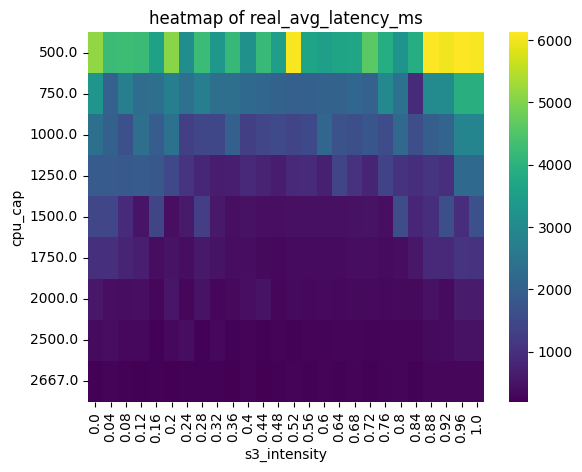

In [234]:
# Visualizes cross-section s3 intensity and CPU access.


def create_heatmap(df, x_key, y_key, val_key):
    fig_df = df[[y_key, x_key, val_key]].astype(float)

    heatmap_data = fig_df.pivot(index=y_key, columns=[x_key], values=[val_key])
    sns.heatmap(
        heatmap_data,
        cmap="viridis",
        fmt=".1f",
        xticklabels=[s / MAX_STEPS for s in range(MAX_STEPS + 1)],
    )

    # Set labels and title
    plt.xlabel(x_key)
    plt.ylabel(y_key)
    plt.title(f"heatmap of {val_key}")

    # Show the plot
    plt.show()


create_heatmap(or_df, "s3_intensity", "cpu_cap", "real_avg_latency_ms")

## Evaluation

In [235]:
def mape(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele) / expected_ele)
    m /= len(expected)
    return m


def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


In [236]:
# Regular data


def get_performance_metrics(df, column_expected, column_experimental):
    cpu_caps = df["cpu_cap"].unique()

    mapes = []
    maes = []
    corrs = []
    pvals = []

    for cap in cpu_caps:
        test_df = df[df["cpu_cap"] == cap].copy()

        mape_score = mape(test_df[column_expected], test_df[column_experimental])
        mapes.append(mape_score)

        mae_score = mae(test_df[column_expected], test_df[column_experimental])
        maes.append(mae_score)

        correlation_coefficient, p_value = spearmanr(
            test_df[column_expected], test_df[column_experimental]
        )
        corrs.append(correlation_coefficient)
        pvals.append(p_value)

    return cpu_caps, mapes, maes, corrs, pvals


cpu_caps, mapes, maes, corrs, pvals = get_performance_metrics(
    or_df, "synth_latency_ms", "real_avg_latency_ms"
)
print(f"{mapes=}")
print(f"{maes=}")
print(f"Spearman {corrs=}")
print(f"Spearman {pvals=}")

mapes=[0.9081954934543893, 0.8327972730027278, 0.7855882593195272, 0.646362946804229, 0.3982710859946877, 0.23140646114231747, 0.13616064551005713, 0.3127311707608586, 0.5876121174699441]
maes=[3949.6766355177674, 2074.2621125215273, 1474.727960271291, 838.887097956982, 418.94718770057165, 179.65530232308112, 57.55851503409132, 85.12785295160958, 141.70551999173605]
Spearman corrs=[0.5596581196581196, 0.6266666666666666, 0.6977777777777777, 0.7894017094017093, 0.7935042735042734, 0.894017094017094, 0.46803418803418795, 0.7723076923076921, 0.44478632478632474]
Spearman pvals=[0.002950729584936458, 0.0006138129542434961, 7.411090799002027e-05, 1.638156032756576e-06, 1.3236240132315497e-06, 7.643576572036174e-10, 0.015896610906031786, 3.7973281387377054e-06, 0.022801672485381674]


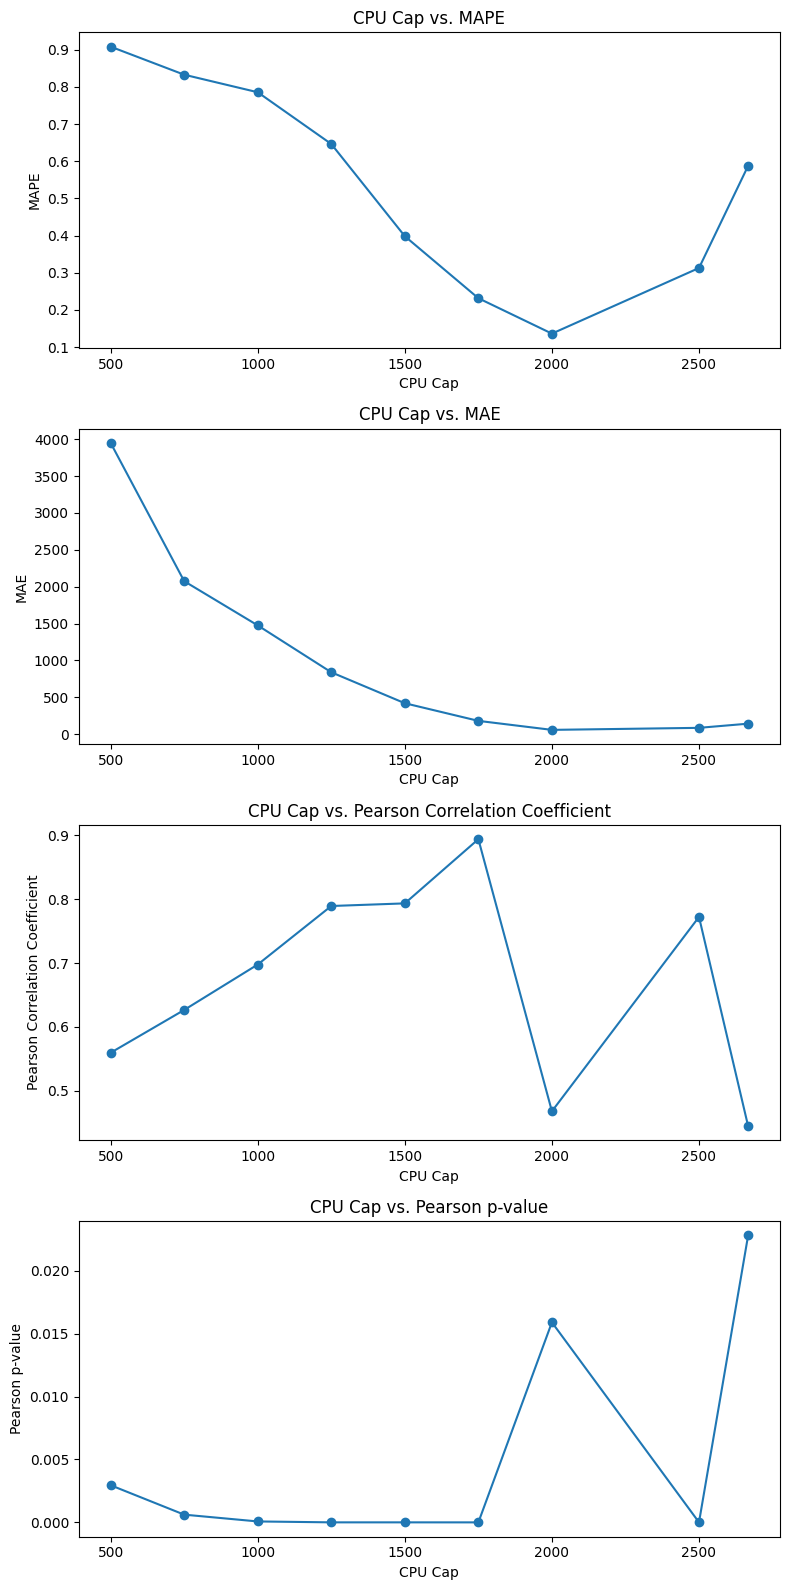

In [237]:
def create_multi_line_charts(x_values_list, y_values_list, xlabels, ylabels):
    """
    Create multiple line charts in subfigures.

    Parameters:
    - x_values_list: List of lists, each containing x-axis values for a line chart.
    - y_values_list: List of lists, each containing y-axis values for a line chart.
    - xlabel: Label for the x-axis (default: 'X Axis Label').
    - ylabel: Label for the y-axis (default: 'Y Axis Label').
    - title: Common title for all line charts (default: 'Line Chart').
    """
    num_charts = len(x_values_list)

    # Create subplots
    fig, axs = plt.subplots(num_charts, 1, figsize=(8, 4 * num_charts))

    # Iterate through each set of x and y values
    for i in range(num_charts):
        ax = axs[i] if num_charts > 1 else axs  # Use a single subplot if only one chart
        ax.plot(
            x_values_list[i],
            y_values_list[i],
            marker="o",
            linestyle="-",
            label=f"Line Chart {i + 1}",
        )

        # Set labels and title for each subplot
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
        title = f"{xlabels[i]} vs. {ylabels[i]}"
        ax.set_title(title)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


y_values = [mapes, maes, corrs, pvals]
y_labels = ["MAPE", "MAE", "Pearson Correlation Coefficient", "Pearson p-value"]
x_values = [cpu_caps for _ in y_values]
x_labels = ["CPU Cap" for _ in y_values]

create_multi_line_charts(x_values, y_values, x_labels, y_labels)

In [238]:
def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


norm_or_df = or_df.copy()

# Normalizes real data.
lat_min, lat_max = min(norm_or_df["real_avg_latency_ms"]), max(
    norm_or_df["real_avg_latency_ms"]
)
norm_or_df.loc[:, "real_avg_latency_ms"] = norm_or_df["real_avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


# Normalizes synthetic data.
lat_min, lat_max = min(norm_or_df["synth_latency_ms"]), max(
    norm_or_df["synth_latency_ms"]
)
norm_or_df.loc[:, "synth_latency_ms"] = norm_or_df["synth_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


def get_performance_metrics_no_mape(df, column_expected, column_experimental):
    cpu_caps = df["cpu_cap"].unique()

    maes = []
    corrs = []
    pvals = []

    for cap in cpu_caps:
        test_df = df[df["cpu_cap"] == cap].copy()

        mae_score = mae(test_df[column_expected], test_df[column_experimental])
        maes.append(mae_score)

        correlation_coefficient, p_value = spearmanr(
            test_df[column_expected], test_df[column_experimental]
        )
        corrs.append(correlation_coefficient)
        pvals.append(p_value)

    return cpu_caps, maes, corrs, pvals


cpu_caps, maes, corrs, pvals = get_performance_metrics_no_mape(
    norm_or_df, "synth_latency_ms", "real_avg_latency_ms"
)

print(f"{maes=}")

maes=[0.4243096327168821, 0.2212028324839116, 0.1897511221331102, 0.16355723155868274, 0.19173067672647576, 0.22202990858840524, 0.24997540359553183, 0.2580614426877139, 0.26717296272384267]


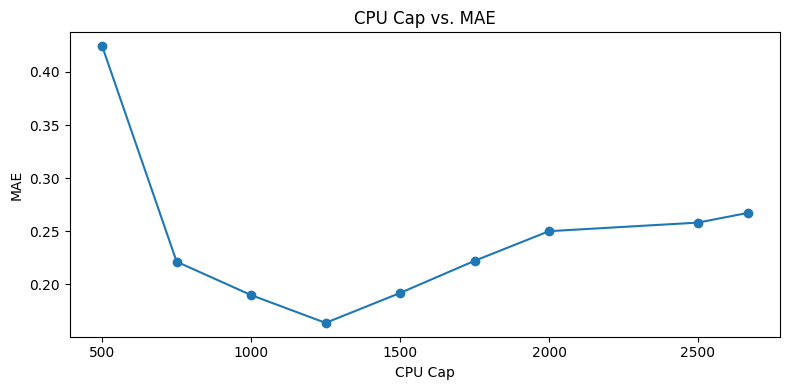

In [239]:

y_values = [maes]
y_labels = ["MAE"]
x_values = [cpu_caps for _ in y_values]
x_labels = ["CPU Cap" for _ in y_values]

create_multi_line_charts(x_values, y_values, x_labels, y_labels)